In [1]:
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata --quiet
!pip3 install torch torchaudio torchvision torchtext torchdata --quiet
!pip install torchdiffeq --quiet

In [2]:
import torch
from torch import nn, optim, Tensor, tensor
import torchdiffeq as tdf
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from IPython.display import clear_output

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

## Logistic Function
> The dynamical equation we want to learn is:

$$
\dot{y} = r\left(1-\frac{y}{K}\right)y
$$
where:
- $y$ is the population size.
- $r$ is the growth rate.
- $K$ is the capacity of environment.

## ODEFunc
> The MLP consists of 3 layer, each activation function is `Tanh()`,





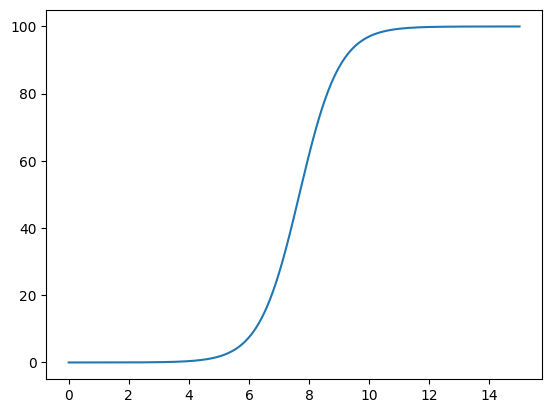

In [4]:
t = torch.linspace(0,15,1500).to(device)

class growth_model(nn.Module):
  def __init__(self, *args):
    super(growth_model, self).__init__()
    self.K, self.r = args

  def forward(self, t, y):
    return self.r * y * (1 - y/self.K)


true_y0 = torch.Tensor([0.001]).to(device)
true_model = growth_model(100, 1.5).to(device)
with torch.no_grad():
  true_y = tdf.odeint(true_model, true_y0, t)

class ODEFunc(nn.Module):
  def __init__(self):
    super(ODEFunc, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(1,50),
        nn.Tanh(),
        nn.Linear(50,50),
        nn.Tanh(),
        nn.Linear(50,1)
    )
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 1)
        nn.init.constant_(m.bias, 0)

  def forward(self, t, y):
    return self.net(y)



def get_batch(batch_time, batch_num,total_time=len(t)):
  s = torch.from_numpy(np.random.choice(np.arange(total_time - batch_time), batch_num, replace=False))
  batch_t = t[:batch_time]
  batch_y0 = true_y[s]
  batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)

  return batch_t.to(device), batch_y0.to(device), batch_y.to(device)

  # batch_y0 =

plt.plot(t.cpu(), true_y.cpu())

# np.choice(np.arange(1000), )

In [5]:
func = ODEFunc().to(device)

def train_epoch(max_epoch, func,lr):
  optimizer = optim.Adam(func.parameters(), lr=lr)
  loss_list = []
  # with progressbar.ProgressBar(max_value=max_epoch) as bar:
  for epoch in range(max_epoch):
    optimizer.zero_grad()
    batch_t, batch_y0, batch_y = get_batch(20, 100)
    pred_y = tdf.odeint_adjoint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()
    # bar.update(epoch)

    if epoch % 100 == 0:
    # loss_list.append(loss.item())
      print(loss.item())

  return loss_list

  # tdf.odeint_adjoint(func,get_batch(20, 100)[1], t)

# loss_list = train_epoch(1000)

In [ ]:
train_epoch(1500,func, 1e-2)
train_epoch(1500,func, 1e-3)
train_epoch(1500,func, 1e-5)
train_epoch(1500,func, 1e-7)

0.8322088122367859
0.5571433901786804
0.43312937021255493


In [ ]:
fig = plt.figure(figsize=(10,10))
t2 = torch.linspace(0,10,1000).to(device)
ax = fig.add_subplot(111)
true_y02 = torch.Tensor([1]).to(device)
with torch.no_grad():
  y_true = tdf.odeint(true_model, true_y02, t2)
  y_pred = tdf.odeint(func, true_y02, t2)
ax.plot(t2.cpu(), y_true.cpu(), label="true")
ax.plot(t2.cpu(), y_pred.detach().numpy(), label="pred", linestyle='--')
ax.legend()